## Investigating Maternal Health: Crude Death Rates in South America

### Introduction
Maternal health is a critical indicator of the overall well-being of a population, reflecting the quality of healthcare services and societal conditions. In this analysis, we explore the maternal health landscape of South America, quantifing crude death rates (CDRs) from maternal conditions. Using data from WHO Mortality Database and the UN WPP, we seek to gain insights into the trends and patterns of maternal mortality in the region.

### Assumptions
1. **Representativeness:** We assume that the available data adequately represents the female population of South America for each respective year.
2. **Accuracy of Data:** We assume the accuracy and reliability of the mortality and population data provided by the WHO Mortality Database and the UN WPP.
3. **Consistency in Reporting:** We assume consistent reporting practices across countries in South America regarding maternal deaths and population statistics.

### Results and Conclusion
Some values are stated as N/A. This is due to the represented population in the data relating to the number of deaths being below 80% of the population estimates for the respective country and year.

Crude death rate from maternal conditions per 100,000 females in South America for specific for years of interest:
- **1970:** N/A
- **1979:** N/A
- **1986:** 2.60
- **2011:** 1.71
- **2017:** 1.56

These findings suggest significant progress has been made in reducing maternal mortality, but that further progress needs to be made. The insights from this analysis could guide policymakers and healthcare professionals in implementing targeted interventions to improve maternal health outcomes in the region. However, it's essential to acknowledge the limitations of our analysis, including potential data gaps and the need for ongoing monitoring and evaluation to ensure continued progress in maternal healthcare provision.

**Note**: Age standardisation has not been used for this analysis, as it was not requested by the project manager. Using age-standardised values is a recommended future improvement to allow better comparison between different countries and over time.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#### Import Data

In [3]:
# Read continent data
continents_cols = ['Entity', 'Code', 'Continent']
continents_df = pd.read_csv('data/continents-according-to-our-world-in-data.csv',usecols=continents_cols)

# Read population data
population_cols = {'ISO3_code': str, 'Time': int, 'PopFemale': float}
populaton_df = pd.read_csv('data/WPP2022_TotalPopulationBySexJuly1.csv', usecols=population_cols.keys(), dtype=population_cols)

# Read deaths data
deaths_cols = ['Country Code','Year','Sex','Age Group','Number']
deaths_df = pd.read_csv('data/WHOMortalityDatabase_Deaths.csv', usecols=deaths_cols, index_col=False)

#### Clean DataFrame Headers

In [4]:
# Rename continent data columns
continents_colnames = {'Entity': 'Country',
                       'Code': 'ISO3_code',
                       }
continents_df.rename(columns=continents_colnames, inplace=True)    

# Rename population data columns
population_colnames = {'Time': 'Year',
                       'PopFemale': 'Female population',
                       }
populaton_df.rename(columns=population_colnames,inplace=True)

# Rename death data columns
deaths_colnames = {'Country Code': 'ISO3_code',
                   'Number': 'Number of deaths'}

deaths_df.rename(columns=deaths_colnames, inplace=True)

#### Clean population data

We will use the ISO3 country code to indentify countries when later merging DataFrames. Parts of the population data do not include an ISO3 code as they represent regions or continents, so we will first drop this data as we are only interested in country specific populations.

In [5]:
# Check how many rows do not have an ISO 3 code for reference
populaton_df['ISO3_code'].isna().sum()

252957

In [6]:
# Drop rows without an ISO 3 code
countries_population_df = populaton_df.dropna(subset='ISO3_code')

#### Clean maternal deaths data

Filter to only rows for 'All' age group and Sex = Female.

In [7]:
# Create mask to filter by female and 'All' age group
deaths_age_sex_mask = (deaths_df['Age Group'] == '[All]') & (deaths_df['Sex'] == 'Female')

# Apply the mask
all_age_deaths_df = deaths_df[deaths_age_sex_mask]

In [8]:
# Drop the 'Age Group' and 'Sex' columns as we are now only dealing with all ages and females
number_of_deaths_df = all_age_deaths_df.drop(['Age Group', 'Sex'], axis=1).reset_index(drop=True)

#### Merge Population and Continent DataFrames
We need to define which continents countries belong to, so we will merge the population and continents definition DataFrames.

In [9]:
# Merge dataframes on the ISO3 code columns
population_continents_df = pd.merge(left=countries_population_df, right=continents_df, how='left', on='ISO3_code')

#### Merge the population DataFrame (including continents) with maternal deaths DataFrame
We will merge these using both the ISO 3 code and the year to add the number of deaths for each country and each year.

In [10]:
# Merge dataframes on both ISO 3 code and Year
population_and_deaths_df = pd.merge(left=population_continents_df, right=number_of_deaths_df, how='left', on=['ISO3_code', 'Year'])

In [11]:
# Check the merged dataframe
population_and_deaths_df.head()

,ISO3_code,Year,Female population,Country,Continent,Number of deaths
0,BDI,1950,1174.340,Burundi,Africa,NaN
1,BDI,1951,1198.705,Burundi,Africa,NaN
2,BDI,1952,1222.726,Burundi,Africa,NaN
3,BDI,1953,1246.363,Burundi,Africa,NaN
4,BDI,1954,1270.051,Burundi,Africa,NaN


#### Filter the population/death DataFrame
Filter to only countries within South America, and year less than or equal to 2022 (as this is the most recent year where data for maternal deaths is available).

In [12]:
# Create a mask to filter the data
continent_and_year_mask = (population_and_deaths_df['Continent']=='South America') & (population_and_deaths_df['Year'] <= 2022)

# Apply the mask and reset index
south_america_pop_df = population_and_deaths_df[continent_and_year_mask].reset_index(drop=True)

#### Discrepencies in population data and continents definition

It can be seen we only have population data for 14 countries, despite the continents definition including 15 countries. The population data provides no population values for South Georgia and the South Sandwich Islands. From researching, it appears the population of South Georgia and the South Sandwich Islands is negligable, and so we will proceed without population values for this country.

In [13]:
# Check the number of countries we have population data for in South America
n_countries_pop_data = south_america_pop_df['Country'].nunique()

# Check the number of countries we have in the continents definition for South America
n_countries_continent_data = continents_df[continents_df['Continent']=='South America']['Country'].nunique()

print(f'Number of countries in population data for South America: {n_countries_pop_data}')
print(f'Number of countries in continents definitions for Sout America: {n_countries_continent_data}')

Number of countries in population data for South America: 14
Number of countries in continents definitions for Sout America: 15


#### Calculate represented population for each country and year
A new column will be used to determine the aggregated represented population values for comparison with the true population. We first convert the population values to absolute values (from thousands). We then create a new column 'Represented population'. This is initially set to 0, and then updated to the countries population if maternal death data is available for that year. Else, it remains as 0. 

In [14]:
# Convert population values to absolute values (from thousands)
south_america_pop_df['Female population'] *= 1000

# Create a new column 'represented_population' and set it to 0 initially
south_america_pop_df['Represented population'] = 0.0

# Set the values of 'represented_population' where 'Number of deaths' is not NaN
south_america_pop_df.loc[~south_america_pop_df['Number of deaths'].isna(), 'Represented population'] = south_america_pop_df['Female population']

#### Aggregate by year to get values at continent level
We will now aggregate the data to combine the data all countries within South America by year.

In [15]:
# Group by 'Year' and sum the population and death values
agg_pop_and_deaths_df = (south_america_pop_df
              .groupby('Year')
              .agg({'Female population': 'sum',
                    'Number of deaths': 'sum',
                    'Represented population': 'sum'})
                .reset_index())

In [16]:
# Check the df
agg_pop_and_deaths_df.tail()

,Year,Female population,Number of deaths,Represented population
68,2018,2.149611e+08,3309.0,193727159.0
69,2019,2.168171e+08,3091.0,195904857.0
70,2020,2.185154e+08,3676.0,197334882.0
71,2021,2.199869e+08,1656.0,71030859.0
72,2022,3.321265e+09,0.0,0.0


#### Calculate the crude death rate (CDR) per 100,000 females
CDR is calculted for each year. Then we check if the represented population >= 80% of the true population. If false, update this value to NaN

$$
CDR = \frac{{\sum_{i} \text{Number of deaths}_{i}}}{{\sum_{i} \text{Total female population}_{i}}} \times 100,000
$$

In [17]:
# Calculate the crude death rate per 100,000 people for each year and round to 2.d.p
agg_pop_and_deaths_df['Crude death rate'] = (
    agg_pop_and_deaths_df['Number of deaths'] / agg_pop_and_deaths_df['Represented population'] * 100000
).round(2)

# Set crude death rate to NaN for years where represented population is less than 80% of true population
agg_pop_and_deaths_df.loc[agg_pop_and_deaths_df['Represented population'] < 0.8 * agg_pop_and_deaths_df['Female population'], 'Crude death rate'] = np.nan

In [18]:
# Check the df
agg_pop_and_deaths_df.tail(5)

,Year,Female population,Number of deaths,Represented population,Crude death rate
68,2018,2.149611e+08,3309.0,193727159.0,1.71
69,2019,2.168171e+08,3091.0,195904857.0,1.58
70,2020,2.185154e+08,3676.0,197334882.0,1.86
71,2021,2.199869e+08,1656.0,71030859.0,NaN
72,2022,3.321265e+09,0.0,0.0,NaN


#### Results
Retrieve CDR values for specific years of interest.

In [19]:
cdr_1970 = agg_pop_and_deaths_df[agg_pop_and_deaths_df['Year'] == 1970]['Crude death rate'].values[0]
cdr_1979 = agg_pop_and_deaths_df[agg_pop_and_deaths_df['Year'] == 1979]['Crude death rate'].values[0]
cdr_1986 = agg_pop_and_deaths_df[agg_pop_and_deaths_df['Year'] == 1986]['Crude death rate'].values[0]
cdr_2011 = agg_pop_and_deaths_df[agg_pop_and_deaths_df['Year'] == 2011]['Crude death rate'].values[0]
cdr_2017 = agg_pop_and_deaths_df[agg_pop_and_deaths_df['Year'] == 2017]['Crude death rate'].values[0]

In [20]:
print('Crude death rates per 100,000 females for years of interest:')
print(f'1970: {cdr_1970}')
print(f'1979: {cdr_1979}')
print(f'1986: {cdr_1986}')
print(f'2011: {cdr_2011}')
print(f'2017: {cdr_2017}')

Crude death rates per 100,000 females for years of interest:
1970: nan
1979: nan
1986: 2.93
2011: 1.78
2017: 1.73


#### Visulations

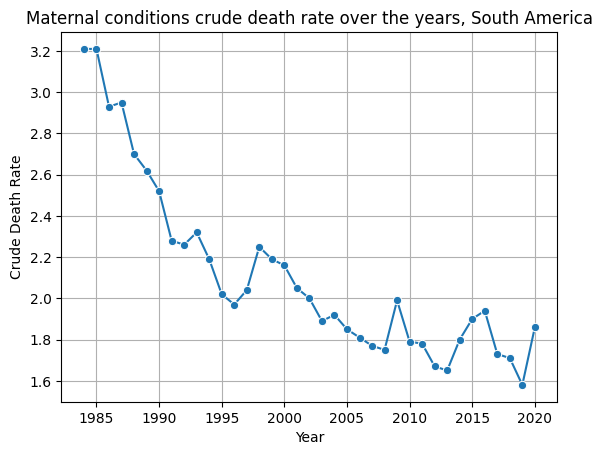

In [21]:
# Plot crude death rate by year
sns.lineplot(data=agg_pop_and_deaths_df, x='Year', y='Crude death rate', marker='o')
plt.title('Maternal conditions crude death rate over the years, South America')
plt.xlabel('Year')
plt.ylabel('Crude Death Rate')
plt.grid(True)
plt.show()

### References

**Maternal mortality data** WHO Mortality Database: https://platform.who.int/mortality/themes/theme-details/topics/topic-details/MDB/maternal-conditions

**Population estimates:** United Nations World Population Prospects (2022): https://population.un.org/wpp/Download/Standard/MostUsed/

**Continent definitions:** Continents according to Our World in Data: https://ourworldindata.org/grapher/continents-according-to-our-world-in-data